## notebook 05: position error precision vs accuracy regressions

In this notebook we calculate accuracy and precision for each participant and condition for Figure 7 of the paper. We then compute a regression predicting accuracy from precision together with 95% confidence intervals.

In [1]:
# importing python packages
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
from scipy.stats import linregress
import os
# importing modules from our analysis pipeline
from utilities import helpers

In [2]:
# set data path and save path
data_root = f"..{os.sep}data{os.sep}"
save_path = f"..{os.sep}figures{os.sep}"
settingsfile = helpers.create_trial_settings_dict_from_session_json(data_root + "experiment_settingsfile.json")

In [3]:
# read in experiment result dataframe
experiment_results = pd.read_csv(data_root + "processed_data.csv", index_col=0)
experiment_results.head()

block_num    trial_name  line_i   experiment       ppid  \
session_num                                                            
1                    1  99_obj_right       0  MM04_PU01_2  MM04_PU01   
1                    1   2_obj_right       1  MM04_PU01_2  MM04_PU01   
1                    1   3_obj_right       2  MM04_PU01_2  MM04_PU01   
1                    1  10_obj_right       3  MM04_PU01_2  MM04_PU01   
1                    1   2_obj_right       4  MM04_PU01_2  MM04_PU01   

             trial_num  trial_num_in_block  start_time  end_time  \
session_num                                                        
1                    1                   1    1007.957  1069.763   
1                    2                   2    1069.763  1143.276   
1                    3                   3    1143.276  1206.921   
1                    4                   4    1206.921  1276.941   
1                    5                   5    1276.941  1352.005   

                           BlockName  ... goalEstimateZ  goalTrueX  goalTrueY  \
session_num                           ...                                       
1            6reps_all_cond_shuffled  ...      2.708552        0.0        0.0   
1            6reps_all_cond_shuffled  ...     -0.698157        0.0        0.0   
1            6reps_all_cond_shuffled  ...      2.127848        0.0        0.0   
1            6reps_all_cond_shuffled  ...     -4.614375        0.0        0.0   
1            6reps_all_cond_shuffled  ...     -1.345040        0.0        0.0   

             goalTrueZ  confidence  flagged  num_objects  err_pos_walk  \
session_num                                                              
1                  0.0    0.043412    False           99      2.708553   
1                  0.0    0.262324    False            2      9.236702   
1                  0.0    0.214372    False            3      8.713744   
1                  0.0    0.291512    False           10      4.695786   
1                  0.0    0.235219    False            2      7.918898   

             err_dist_walk  err_dir_walk  
session_num                               
1                -2.708552      0.004725  
1                 2.298801    -19.717797  
1                -0.616872    -20.276377  
1                 4.627169      1.683901  
1                 2.476553    -16.500153  

[5 rows x 27 columns]

In [4]:
# group dataframe by condition ("num_objects") and participants ("ppid")
grouped = experiment_results.groupby(["num_objects", "ppid"])
# then calculate the median position error
grouped_errors = grouped.median().err_pos_walk
# and the variance of position error
grouped_errors_var = grouped.var().err_pos_walk
# and reset the MultiIndex for easier access
grouped_errors = grouped_errors.reset_index()
grouped_errors_var = grouped_errors_var.reset_index()
# transform accuracy and precision measure to log space
grouped_errors["accuracy"] = np.log(grouped_errors.err_pos_walk)
grouped_errors["precision"] = np.log(grouped_errors_var.err_pos_walk)
grouped_errors.head()

C:\Users\jscherer1\AppData\Local\Temp\ipykernel_16164\343388467.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_errors = grouped.median().err_pos_walk
C:\Users\jscherer1\AppData\Local\Temp\ipykernel_16164\343388467.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_errors_var = grouped.var().err_pos_walk


num_objects       ppid  err_pos_walk  accuracy  precision
0            0  MM04_PU01     14.232398  2.655521   4.941324
1            0  MM04_PU03      8.602727  2.152079   2.748478
2            0  MM04_PU04     10.754587  2.375332   4.184749
3            0  MM04_PU05     12.392232  2.517070   3.460713
4            0  MM04_PU06      6.506571  1.872813   2.821759

In [5]:
performance = helpers.get_performance_dict(data_root + "processed_data.csv", colormap="pink", colormap_part=[0, .75])
performance_dict = performance["performance_dict"]
ppid_colormap = performance["colormap"]
# use performance dictionary to make a column "performance_score" that holds for each datapoint 
# ...the performance in 99 object condition
performance_score = [performance_dict[ppid] for ppid in grouped_errors.ppid]
grouped_errors["performance_score"] = performance_score

## Figure 7

Here we plot the main panel of figure 7 of the paper. Please note that the exemplary figures a-f are generated in notebook nb_01_trajectory_plotting.

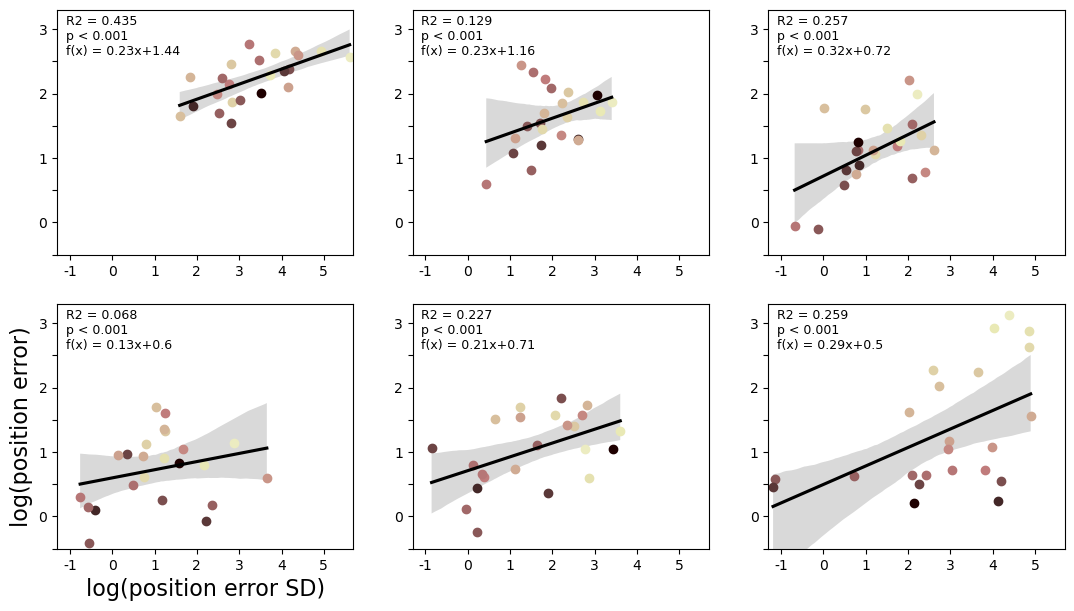

In [6]:
fig, axs = plt.subplots(2,3)

# get all conditions to loop through them
conditions = np.unique(grouped_errors.num_objects)
for idx, cond in enumerate(conditions):
    cond_grouped_errors = grouped_errors.loc[grouped_errors.num_objects==cond]
    sb.regplot(data=cond_grouped_errors, x="precision", y="accuracy", scatter=False, color="k", ax=axs[np.unravel_index(idx, (2,3))])
    for ppid in np.unique(cond_grouped_errors.ppid):
        prec = cond_grouped_errors[cond_grouped_errors.ppid==ppid].precision
        acc = cond_grouped_errors[cond_grouped_errors.ppid==ppid].accuracy
        c = performance["color_dict"][ppid]
        axs[np.unravel_index(idx, (2,3))].scatter(prec, acc, color=c)

    regress = linregress(cond_grouped_errors.precision, cond_grouped_errors.accuracy) 
    r2_string = str(np.round(regress.rvalue**2,3))
    p_string = str(np.round(regress.pvalue,3))
    intercept_string = str(np.round(regress.intercept,2))
    slope_string = str(np.round(regress.slope,2))
    
    axs[np.unravel_index(idx, (2,3))].text(x=-1.1, y=2.6, s=f"R2 = {r2_string}\np < 0.001\nf(x) = {slope_string}x+{intercept_string}", fontsize=9)
    axs[np.unravel_index(idx, (2,3))].set_yticks([-0.5,0,0.5,1,1.5,2,2.5,3])
    axs[np.unravel_index(idx, (2,3))].set_yticklabels(["","0","","1","","2","","3"])
    axs[np.unravel_index(idx, (2,3))].set_xticks([-1,0,1,2,3,4,5])
    axs[np.unravel_index(idx, (2,3))].set_xticklabels(np.array([-1,0,1,2,3,4,5]).astype(str))
    axs[np.unravel_index(idx, (2,3))].set_xlim([-1.3, 5.7])
    axs[np.unravel_index(idx, (2,3))].set_ylim([-0.5, 3.3])
    axs[np.unravel_index(idx, (2,3))].set_xlabel("")
    axs[np.unravel_index(idx, (2,3))].set_ylabel("")

axs[np.unravel_index(3, (2,3))].set_xlabel("log(position error SD)", fontsize=16)
axs[np.unravel_index(3, (2,3))].set_ylabel("log(position error)", fontsize=16)
fig.set_size_inches(13,7)
filename = "figure_7.{}"
fig.savefig(save_path + filename.format("svg"))
fig.savefig(save_path + filename.format("png"))
fig.savefig(save_path + filename.format("pdf"))
